# Training SVC

## Distribution of Data

Need to make sure that the training data is normalized and has almost equal number of Car and Non-Car samples

Total Cars: 1196
Total Non-Cars: 1125
Total Data: 2321
Total Training: 1856
Total Test: 464


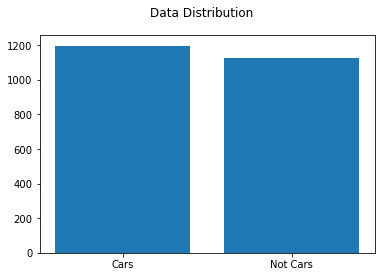

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

#cars = glob.glob('./vehicles/**/*.png', recursive=True)
#notcars = glob.glob('./non-vehicles/**/*.png', recursive=True)

cars = glob.glob('./vehicles_smallset/**/*.jpeg', recursive=True)
notcars = glob.glob('./non-vehicles_smallset/**/*.jpeg', recursive=True)

count = len(cars) + len(notcars)

print('Total Cars:', len(cars))
print('Total Non-Cars:', len(notcars))
print('Total Data:', count)
print('Total Training:', int(count * 0.8))
print('Total Test:', int(count * 0.2))

data = [len(cars), len(notcars)]
index = np.arange(2)
plt.bar(index, data)
plt.xticks(index, ('Cars', 'Not Cars'))
plt.suptitle('Data Distribution')
plt.show()

## Common Functions

In [2]:
from skimage.feature import hog

# returns between 0 and 1
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features / 255.0

def color_hist(img, nbins=[32, 32, 32], bins_range=(0, 256)):
    channel_hist = []
    
    if len(img.shape) > 2:
        if (np.max(img[:,:,0]) <= 1) and (bins_range[1] > 1):
            print('Looks like you are reading PNG with 0..1 but calling bins_range with 0..256')
            
        for i in range(img.shape[-1]):
            channel_hist.append(np.histogram(img[:,:,i], bins=nbins[i], range=bins_range)[0])
    else:
        channel_hist.append(np.histogram(img, bins=nbins[0], range=bins_range)[0])

    hist_features = np.concatenate(channel_hist)
    return hist_features

def load_image(file, color_space):
    img = cv2.imread(file)
    space = eval('cv2.COLOR_BGR2' + color_space)
    return cv2.cvtColor(img, space)

def get_laplacian(channel):
    img = cv2.GaussianBlur(channel, (3,3), 0)
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    return laplacian

def abs_sobel_thresh(channel, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.abs(sobel)
    scaled = np.uint8(255.0 * abs_sobel / np.max(abs_sobel))

    mask = (scaled >= thresh[0]) & (scaled <= thresh[1])

    grad_binary = np.zeros_like(channel)
    grad_binary[mask] = 1
    return grad_binary


def mag_thresh(channel, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    mag = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled = np.uint8(255.0 * mag / np.max(mag))

    mask = (scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])

    mag_binary = np.zeros_like(channel)
    mag_binary[mask] = 1
    return mag_binary

def dir_threshold(channel, sobel_kernel=3, thresh_deg=(0, 90)):
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    dir_sobel = np.arctan2(np.abs(sobely), np.abs(sobelx))

    thresh_rad = [thresh_deg[0] * np.pi / 180.0, thresh_deg[1] * np.pi / 180.0]
    mask = (dir_sobel >= thresh_rad[0]) & (dir_sobel <= thresh_rad[1])

    dir_binary = np.zeros_like(channel)
    dir_binary[mask] = 1
    return dir_binary

## Color Space Choice

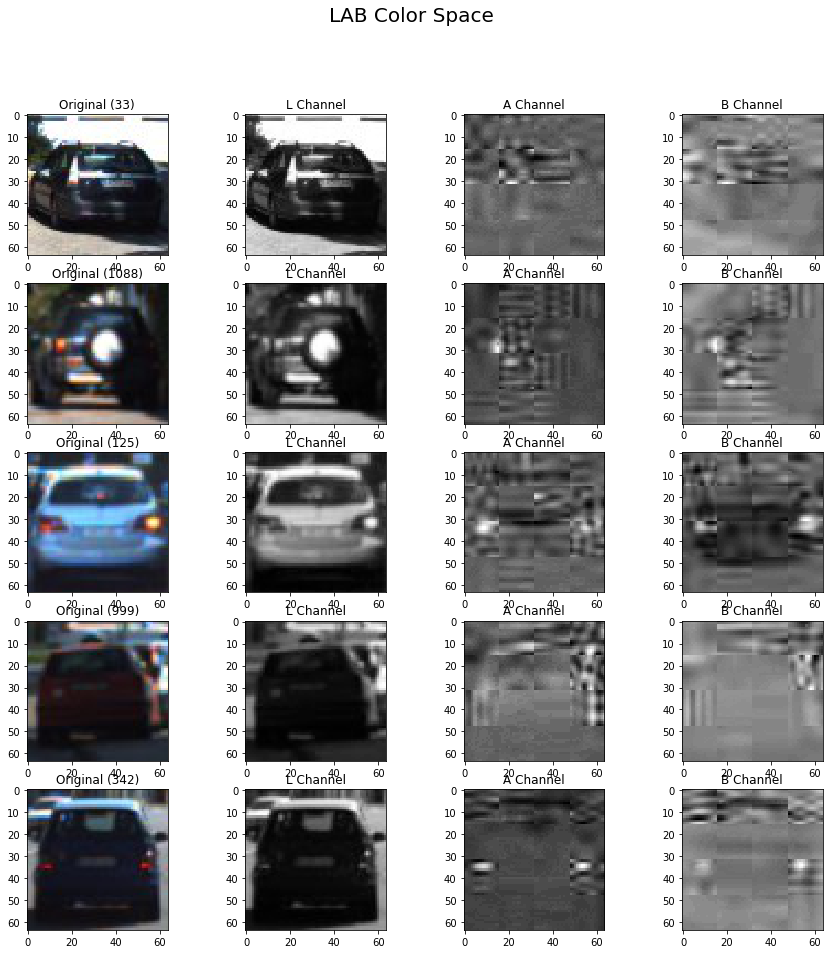

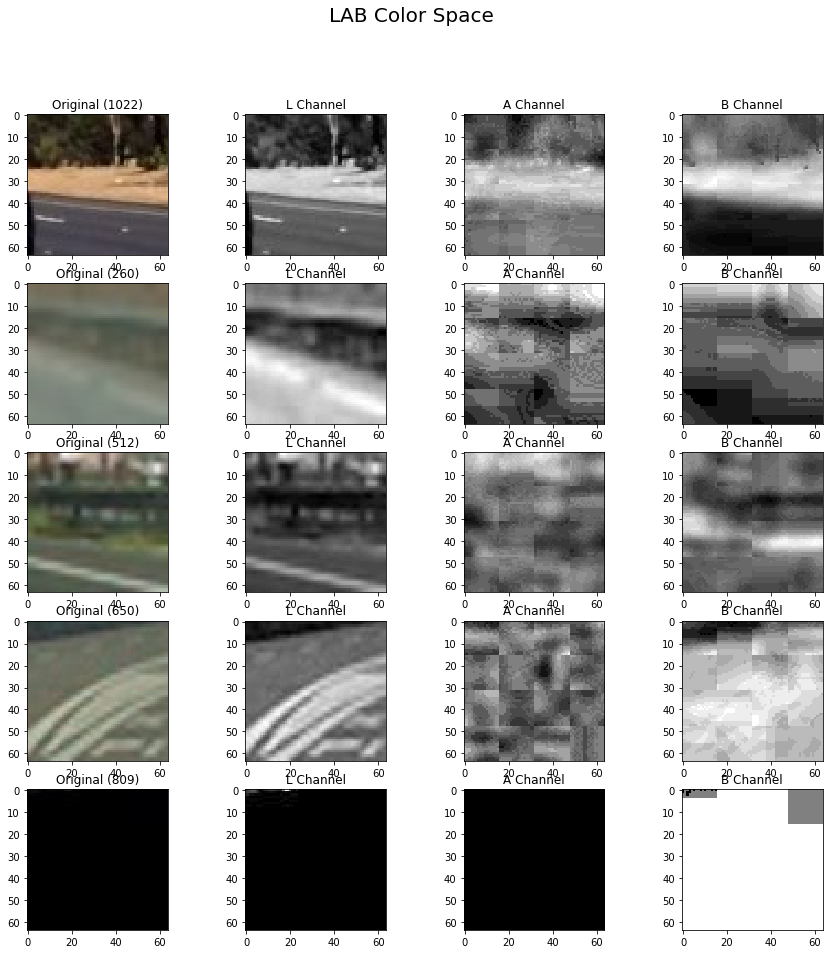

In [3]:
color_space = 'LAB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

def display_random(filenames, n_samples):
    f, ax = plt.subplots(n_samples, 4, figsize=(15,15))
    f.suptitle(color_space + " Color Space", fontsize=20)

    indices = np.random.choice(len(filenames), n_samples, replace=False)
    
    for i in range(n_samples):
        index = indices[i]
        img = load_image(filenames[index], color_space)
        rgb = load_image(filenames[index], 'RGB')

        ax[i,0].imshow(rgb)
        ax[i,0].set_title('Original ({})'.format(index))

        for j in range(3):
            ax[i,1 + j].imshow(img[:,:,j], cmap='gray')
            ax[i,1 + j].set_title(color_space[j] + ' Channel')

display_random(cars, 5)
display_random(notcars, 5)
plt.show()

## Hog Test Sample

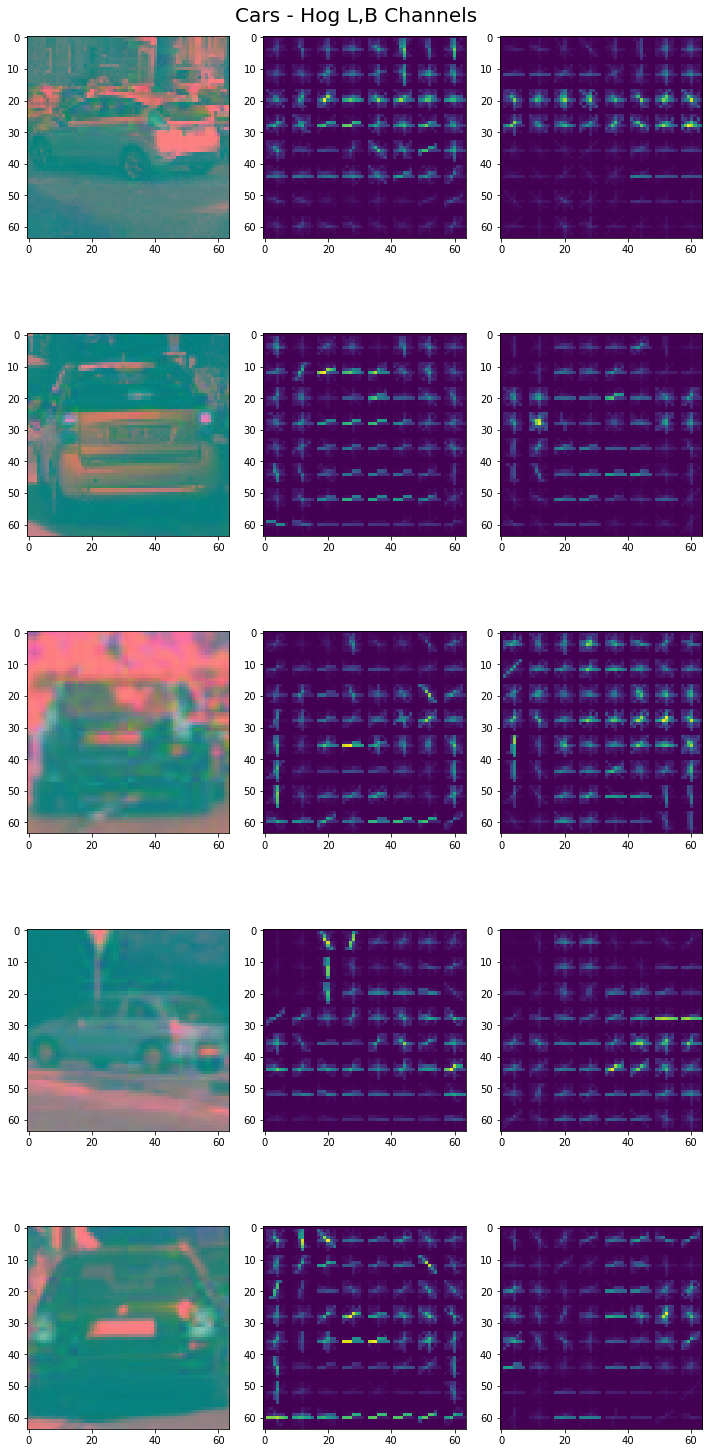

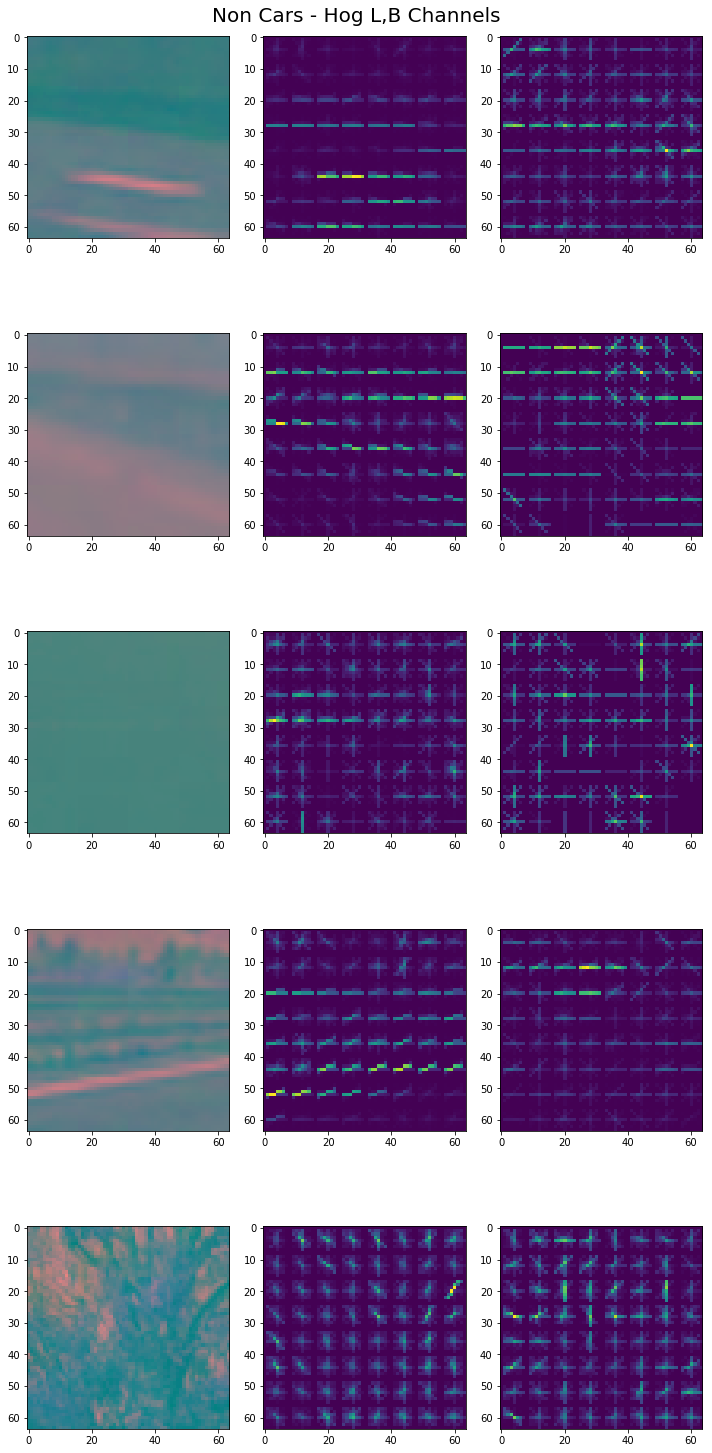

In [4]:
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block

n_samples = 5

def get_hog_features(channel, visualise = False, ravel=False):
    orient = 12
    pix_per_cell = 8
    cell_per_block = 3

    hog_features = hog(channel, orientations=orient, 
                pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block, cell_per_block), 
                transform_sqrt=True, 
                visualise=visualise, 
                feature_vector=True,
                block_norm='L1-sqrt')
    
    if ravel == True:
        return np.ravel(hog_features)
    
    return hog_features

def show_hog(title, filenames):
    indices = np.random.choice(len(filenames), n_samples)
    
    f, ax = plt.subplots(n_samples, 3, figsize=(10,21))
    f.suptitle(title, fontsize=20)

    for i in range(n_samples):
        index = indices[i]

        img = load_image(filenames[index], color_space)
        
        _, hog_img_l = get_hog_features(img[:,:,0], True) 
        _, hog_img_b = get_hog_features(img[:,:,2], True)
        
        ax[i,0].imshow(img)
        ax[i,1].imshow(hog_img_l)
        ax[i,2].imshow(hog_img_b)
    
    f.tight_layout()

show_hog('Cars - Hog L,B Channels', cars)
show_hog('Non Cars - Hog L,B Channels', notcars)

plt.show()

## Spatial Features
Shows effects of spatial size, which is just a resize of image and then raveling it

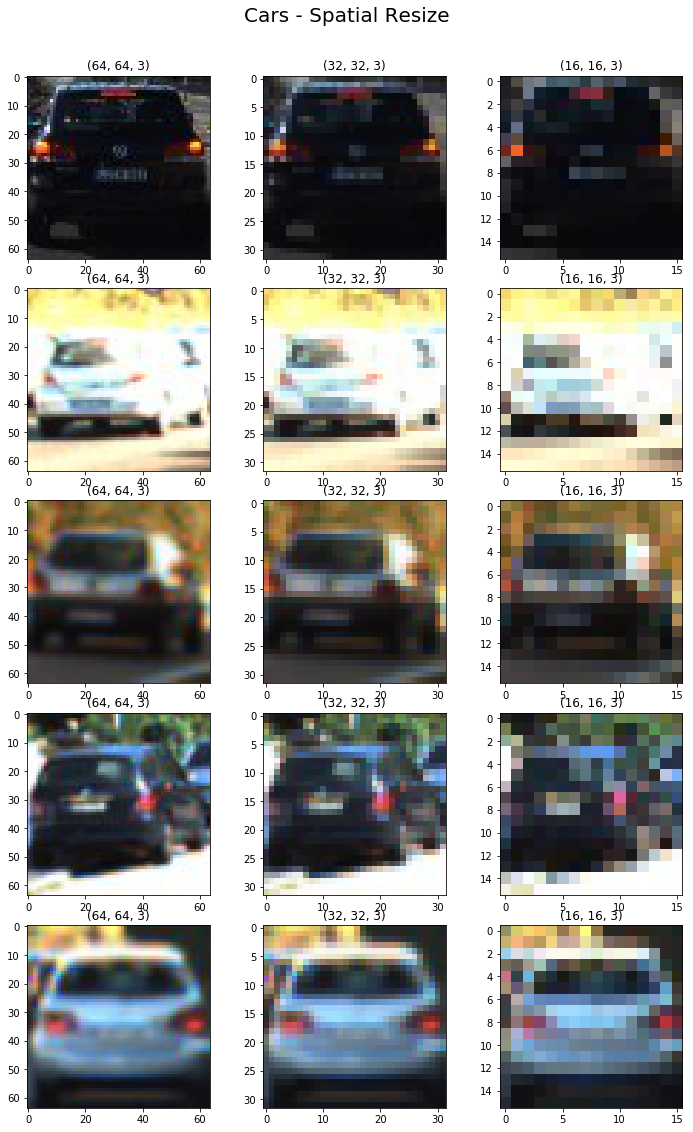

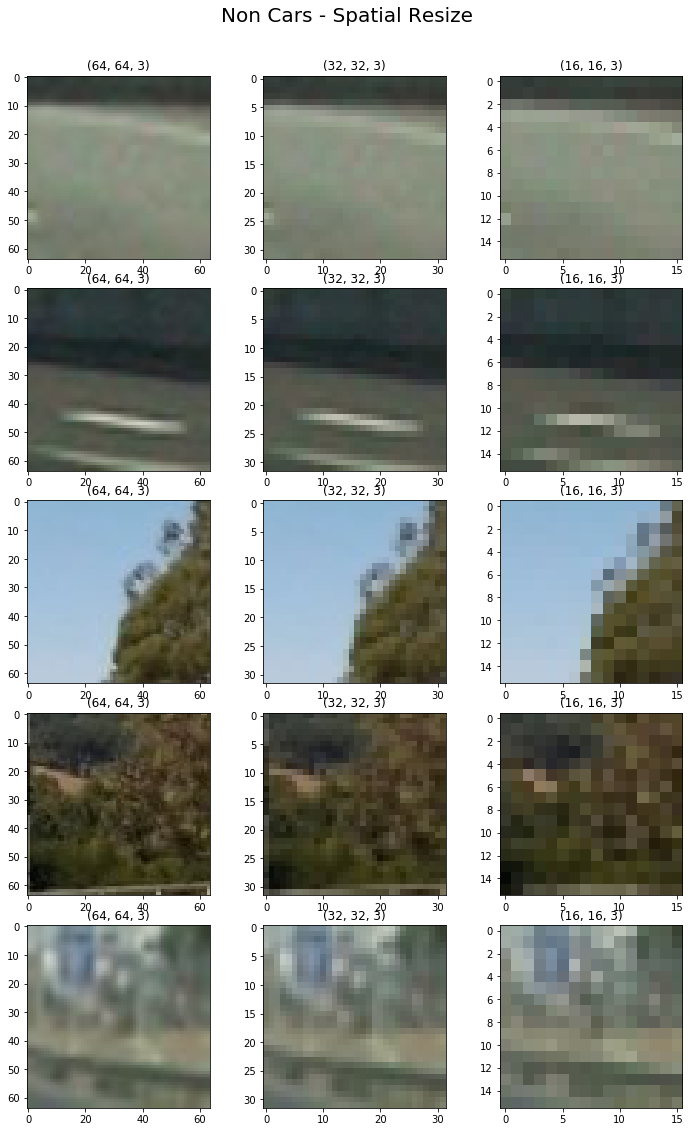

In [5]:
n_samples = 5

def show_resize(title, filenames):
    indices = np.random.choice(len(filenames), n_samples)
    
    f, ax = plt.subplots(n_samples, 3, figsize=(10,16))
    f.tight_layout()
    f.suptitle(title, fontsize=20)
    f.subplots_adjust(top=0.92)
    
    for i in range(n_samples):
        index = indices[i]

        img = []
        img.append(load_image(filenames[index], 'RGB'))
        img.append(cv2.resize(img[0], (32,32)))
        img.append(cv2.resize(img[0], (16,16)))
        
        for j in range(len(img)):
            ax[i,j].imshow(img[j])
            ax[i,j].set_title(img[j].shape)

show_resize('Cars - Spatial Resize', cars)
show_resize('Non Cars - Spatial Resize', notcars)
plt.show()

## Color Histogram

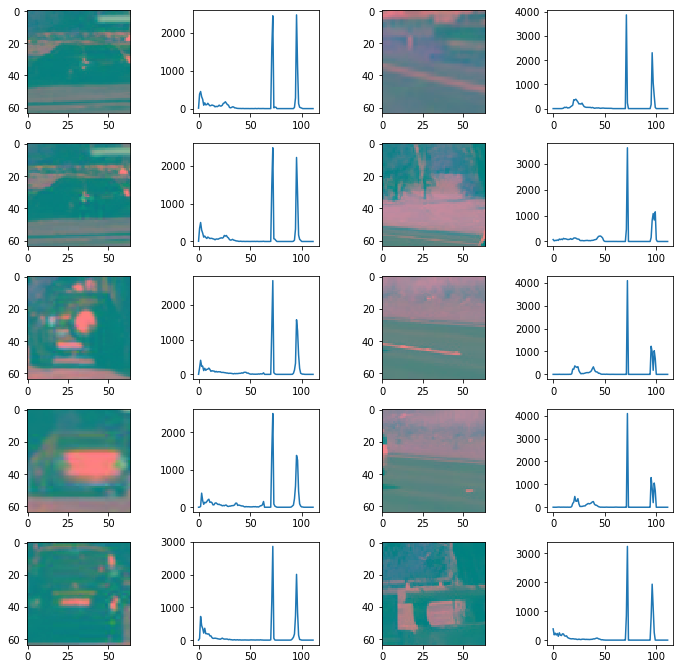

In [6]:
n_samples = 5

indices = np.random.choice(len(cars), n_samples)

f, ax = plt.subplots(n_samples, 4, figsize=(10,10))
f.tight_layout()
f.subplots_adjust(top=0.92)

for i in range(n_samples):
    index = indices[i]
    
    color_space = 'LAB'
    
    car_img = load_image(cars[index], color_space)
    notcar_img = load_image(notcars[index], color_space)
    
    nbins = [64, 16, 32]
    car_features = color_hist(car_img, nbins=nbins)
    notcar_features = color_hist(notcar_img, nbins=nbins)
    
    ax[i,0].imshow(car_img)
    ax[i,1].plot(car_features)
    ax[i,2].imshow(notcar_img)
    ax[i,3].plot(notcar_features)

plt.show()

## Gradient of Image

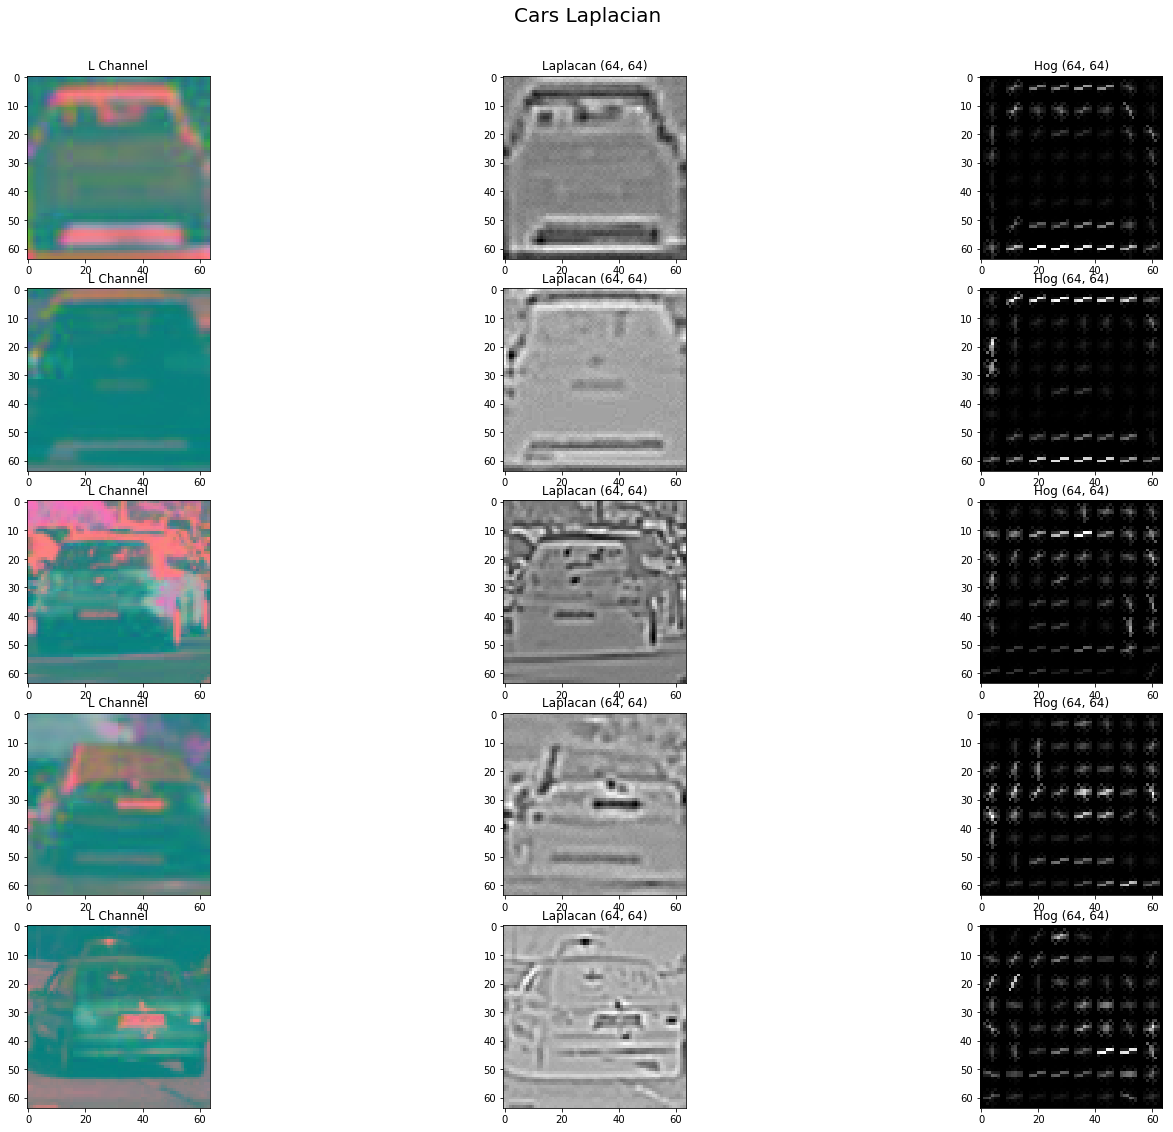

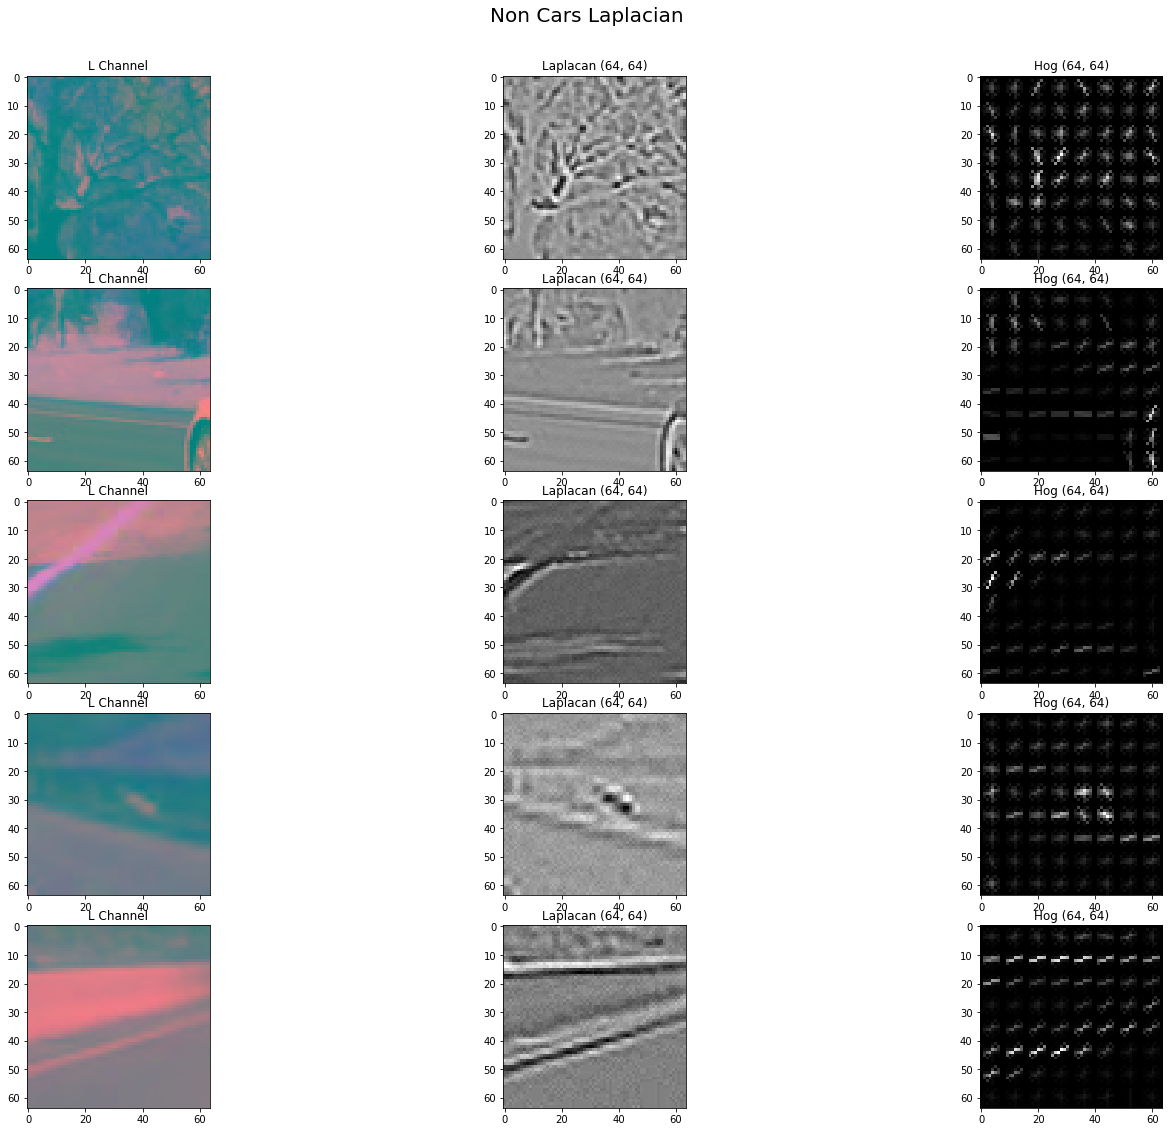

In [7]:
def show_grad(filenames, index):
    #gray = load_image(filenames[index], 'GRAY')
    img = load_image(filenames[index], 'LAB')
    gray = img[:,:,0]
    img = cv2.GaussianBlur(gray, (3,3), 0)
    
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    
    f, ax = plt.subplots(1, 4, figsize=(10,5))
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(laplacian, cmap='gray')
    ax[2].imshow(sobelx, cmap='gray')
    ax[3].imshow(sobely, cmap='gray')

def get_laplacian_hog(channel, visualise = False, ravel = False):
    laplacian = get_laplacian(channel)
    hog_laplacian = hog(laplacian, orientations=9, 
                            pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), 
                            transform_sqrt=False, 
                            visualise=visualise, 
                            feature_vector=False,
                            block_norm='L2-Hys')
    
    if ravel == True:
        return np.ravel(hog_laplacian)
    
    return hog_laplacian
    
def show_laplac(title, filenames):
    indices = np.random.choice(len(filenames), n_samples)
    
    f, ax = plt.subplots(n_samples, 3, figsize=(20,16))
    f.tight_layout()
    f.suptitle(title, fontsize=20)
    f.subplots_adjust(top=0.92)

    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block

    for i in range(n_samples):
        index = indices[i]
        
        img = load_image(filenames[index], 'LAB')
        L = img[:,:,0]

        _, hog_img_l = get_laplacian_hog(L, visualise=True)

        laplacian = get_laplacian(L)

        ax[i,0].imshow(img, cmap='gray')
        ax[i,0].set_title('L Channel')
        ax[i,1].imshow(laplacian, cmap='gray')
        ax[i,1].set_title('Laplacan ' + str(laplacian.shape))
        ax[i,2].imshow(hog_img_l, cmap='gray')
        ax[i,2].set_title('Hog ' + str(hog_img_l.shape))

        
show_laplac('Cars Laplacian', cars)
show_laplac('Non Cars Laplacian', notcars)

plt.show()

## Features Chosen

Color Space: LAB

Hog of L and B channels

Hog of LapLacian of L Channel

[Spatial Features 32 x 32][Hog Laplacian of 16x16][Hog of L Channel 32 x 32][Hog of B Channel 32 x 32]

In [8]:
from skimage.feature import hog
import pickle
import os

hog_channel = [0,2]
spatial_size = (16, 16) # Spatial binning dimensions

hist_bins = 48    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


def extract_features(imgs):
    color_space = 'LAB'
    
    features = []

    # Iterate through the list of images
    for index, file in enumerate(imgs):
        file_features = []

        feature_image = load_image(file, color_space)
        if feature_image.shape[0] != 64:
            print('Images should be 64x64')
        
        L = feature_image[:,:,0]
        B = feature_image[:,:,2]
        
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
        
#         print(np.min(spatial_features), np.max(spatial_features))
        
        hog_l = get_hog_features(L, ravel=True)
        hog_b = get_hog_features(L, ravel=True)

#         print(np.min(hog_l), np.max(hog_l))
#         print(np.min(hog_b), np.max(hog_b))

        file_features.append(hog_l)
        file_features.append(hog_b)
        
        hog_laplacian_l = get_laplacian_hog(L, ravel=True)
        hog_laplacian_b = get_laplacian_hog(B, ravel=True)

#         print(np.min(hog_laplacian_l), np.max(hog_laplacian_l))
#         print(np.min(hog_laplacian_b), np.max(hog_laplacian_b))

        file_features.append(hog_laplacian_l)
        file_features.append(hog_laplacian_b)
                
        combined = np.concatenate(file_features)
        features.append(combined)
        
        print(index, end='\r')
        
    # Return list of feature vectors
    return np.array(features)
    
def create_data_file(filename):
    print('Computing car features...')
    car_features = extract_features(cars)
    print('Car features computed:', car_features.shape)

    print('Computing not-car features...')
    notcar_features = extract_features(cars)
    print('Not Car features computed:', notcar_features.shape)

    print('Combining car and not-car features')
    X = np.vstack((car_features, notcar_features)).astype(np.float64) 

    print('Normalizing combined features')
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    print('Settng Y Labels')
    y = np.concatenate((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    with open(filename, 'wb') as f:
        data = {'scaled_X': scaled_X, 'y': y}
        pickle.dump(data, f)
    
    print('Data saved')

filename = 'train_data.p'        

if not os.path.exists(filename):
    create_data_file(filename)
else:
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        
    scaled_X = data['scaled_X']
    y = data['y']
    
    print('Data restored')

Computing car features...
Car features computed: (1196, 12072)
Computing not-car features...
Not Car features computed: (1196, 12072)
Combining car and not-car features
Normalizing combined features
Settng Y Labels
Data saved


In [10]:
with open(filename, 'rb') as f:
    data = pickle.load(f)

scaled_X = data['scaled_X']
y = data['y']

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Training set shape:', X_train.shape)
print('Training set Y shape:', y_train.shape)
print('Testing set shape:', X_test.shape)
print('Testing set Y shape:', y_test.shape)


Training set shape: (1913, 12072)
Training set Y shape: (1913,)
Testing set shape: (479, 12072)
Testing set Y shape: (479,)


## SVM Training

In [11]:
svc = LinearSVC()

t = time.time()
print('Starting training at:', t)

svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# t = time.time()

# print('Time for accuracy testing', t - t2)


Starting training at: 1495273270.5966644
50.27 Seconds to train SVC...


In [ ]:
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [ ]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), 
                    xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
